# Classificando HPAs

Percorre os arquivos baixados por `hpa_usage.ipynb` no diretório `search_results` e classifica-os de acordo com suas características.

In [1]:
import os
import subprocess
import re
import yaml
import requests
from datetime import datetime, timedelta
from pathlib import Path

from joblib import Parallel, delayed
from dotenv import dotenv_values
from ghapi.core import GhApi, HTTP422UnprocessableEntityError, HTTP404NotFoundError, HTTP403ForbiddenError
from ghapi.page import paged
import pandas as pd
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

import utils

pd.set_option('display.max_colwidth', 2000)

# Tema padrão para os gráficos
plt.style.use('bmh')


## Definição de funções

In [131]:
def is_helm_template(content):
    # Detects Helm template patterns in the file content
    return bool(re.search(r'{{.*}}', content))


def parse_yaml_documents(content):
    # Parses YAML content into a list of documents
    try:
        return list(yaml.safe_load_all(content))
    except yaml.YAMLError:
        return []


def extract_metrics_from_spec(spec, debug=False):
    # Extracts metric information from the HPA spec
    metrics_info = []
    metrics = spec.get('metrics', [])
    if debug:
        print("Extracting metrics")
        print(metrics)

    for metric in metrics:
        if isinstance(metric, str):
            metrics_info.append({
                'Metric Name': metric,
                'Metric Type': metric,
                'Target Value': metrics[metric]
            })
        elif not 'type' in metric:
            metrics_info.append({
                'Metric Name': 'CPUUtilizationPercentage',
                'Metric Type': 'CPUUtilizationPercentage',
                'Target Value': spec['CPUUtilizationPercentage']
            })
        else:
            if debug:
                print(f"type {metric.get('type', 'NA')}")
            metric_type = metric.get('type', '')
            metric_details = metric.get(metric_type.lower(), {})
            target = metric_details.get('target', {})
            target_value = target.get('averageValue') or target.get(
                'averageUtilization') or target.get('targetAverageUtilization') or target.get('value')

            metric_name = ''
            if metric_type.lower() == 'resource':
                metric_name = metric_details.get('name', '')
            else:
                metric_name = metric_details.get('metric', {}).get('name', '')

            metrics_info.append({
                'Metric Name': metric_name,
                'Metric Type': metric_type,
                'Target Value': target_value
            })
    if not metrics:
        if 'targetCPUUtilizationPercentage' in spec:
            metrics_info.append({
                'Metric Name': 'targetCPUUtilizationPercentage',
                'Metric Type': 'targetCPUUtilizationPercentage',
                'Target Value': spec['targetCPUUtilizationPercentage']
            })
        if 'cpuUtilization' in spec:
            if debug:
                print(spec['cpuUtilization'].keys())
            metrics_info.append({
                'Metric Name': 'cpuUtilization',
                'Metric Type': 'cpuUtilization',
                'Target Value': spec['cpuUtilization']['targetPercentage']
            })
    return metrics_info


def extract_behavior_from_spec(spec, debug=False):

    behavior = spec.get('behavior', None)
    if behavior is None:
        return None

    scale_up = behavior.get('scaleUp', None)
    scale_down = behavior.get('scaleDown', None)

    if debug:
        print(f"scale_up: {scale_up}")
        print(f"scale_down: {scale_down}")

    if scale_up == None and scale_down == None:
        return None

    result = {
        "scaleUp": None,
        "scaleDown": None
    }

    if scale_up:
        result["scaleUp"] = {
            "stab_window": scale_up.get('stabilizationWindowSeconds', None),
            "select_pol": scale_up.get('selectPolicy', None),
            "policies": [{
                "type": p.get('type', ''),
                "value": p.get('value', 0),
                "periodSeconds": p.get('periodSeconds', 0)
            } for p in scale_up.get('policies', [])]
        }

    if scale_down:
        result["scaleDown"] = {
            "stab_window": scale_down.get('stabilizationWindowSeconds', None),
            "select_pol": scale_down.get('selectPolicy', None),
            "policies": [{
                "type": p.get('type', ''),
                "value": p.get('value', 0),
                "periodSeconds": p.get('periodSeconds', 0)
            } for p in scale_down.get('policies', [])]
        }

    return result


def process_yaml_content(content, debug=False):
    helm_template = is_helm_template(content)

    if helm_template:
        return [{
            'hpa_count': 0,
            'apiVersion': None,
            'Is Helm Template': True
        }]

    documents = parse_yaml_documents(content)
    if debug:
        print(f"Found {len(documents)} documents")
    hpa_definitions = []

    for doc in documents:
        if isinstance(doc, dict) and doc.get('kind') == 'HorizontalPodAutoscaler':
            if debug:
                print(f"Found hpa #{len(hpa_definitions)+1}")
            api_version = doc.get('apiVersion', '')
            spec = doc.get('spec', {})

            metrics = extract_metrics_from_spec(spec, debug)
            behavior = extract_behavior_from_spec(spec, debug)
            if debug:
                print(f"with {len(metrics)} metrics")
            hpa_definitions.append({
                'hpa_count': len(hpa_definitions)+1,
                'apiVersion': api_version,
                'Is Helm Template': helm_template,
                'Metrics': metrics,
                'Behavior': behavior
            })
    return hpa_definitions


def process_yaml_file(file_path, debug=False):
    # Processes a single YAML file to extract HPA definitions and metrics
    if debug:
        print(f"Processing {file_path}")
    with open(file_path, 'r') as f:
        content = f.read()
        return process_yaml_content(content, debug=debug)


def map_version(api_version):
    # Etiqueta versão do HPA
    # Tudo que contém 'v1' e não contém 'v2' será considerado v1.
    # Caso contrário, consideramos v2.
    if 'v1' in api_version and 'v2' not in api_version:
        return 'v1'
    else:
        return 'v2'


def add_labels(plt, x, y, hpadding=0):
    for i in range(len(x)):
        plt.text(i, y[i]+hpadding, y[i], ha='center')


def wait_for_reset(resource):
    limit = github.rate_limit.get()['resources'][resource]
    reset_time = datetime.fromtimestamp(limit['reset'])
    now = datetime.today().replace(microsecond=0)
    if limit['remaining'] <= 1:
        sleep_duration = reset_time - now
        if sleep_duration.total_seconds() < 0:
            sleep_duration = timedelta(seconds=60)
        print(f"Waiting for {sleep_duration.total_seconds()} seconds")
        time.sleep(sleep_duration.total_seconds())


def get_repo_details(row):
    wait_for_reset('core')

    owner = row['Owner']
    repo = row['Project']

    try:
        repo_details = github.repos.get(owner=owner, repo=repo)
    except HTTP403ForbiddenError:
        print("Limit reached")
        wait_for_reset('core')
        repo_details = github.repos.get(owner=owner, repo=repo)
    except (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
        return {
            'stargazers_count': None,
            'created_at': None,
            'pushed_at': None
        }

    data = {
        'stargazers_count': repo_details['stargazers_count'],
        'created_at': repo_details['created_at'],
        'pushed_at': repo_details['pushed_at']
    }

    return pd.DataFrame(data=data, index=[row.name])


def get_file_commits(row):
    wait_for_reset('core')

    # 'File Path' representa o arquivo local, necessário extrair o caminho dele no repositório
    root_dir = "search_results"
    owner = row['Owner']
    repo = row['Project']
    file_path = row['File Path']
    local_path = Path(root_dir, owner, repo)
    path = Path(file_path).relative_to(local_path)

    try:
        commits = paged(github.repos.list_commits, owner=owner,
                        repo=repo, path=path, per_page=100)
    except HTTP403ForbiddenError:
        print("Limit reached")
        wait_for_reset('core')
        commits = paged(github.repos.list_commits, owner=owner,
                        repo=repo, path=path, per_page=100)
    except (HTTP404NotFoundError, fastcore.net.HTTP404NotFoundError):
        return {
            'file_committed_at': None,
            'message': None
        }

    return [item for page in commits for item in page]


def get_file_first_last_commit(row):
    commits = get_file_commits(row)

    if len(commits) == 0:
        return {
            'file_first_commit': None,
            'file_last_commit': None
        }

    data = {
        'file_first_commit': commits[-1]['commit']['author']['date'],
        'file_last_commit': commits[0]['commit']['author']['date']
    }

    return pd.DataFrame(data=data, index=[row.name])


def download_file_history(row):
    commits = get_file_commits(row)
    print(f"found {len(commits)} commits")

    download_dir = "repos_history"
    root_dir = "search_results"
    owner = row['Owner']
    repo = row['Project']
    file_path = row['File Path']
    local_path = Path(root_dir, owner, repo)
    path = Path(file_path).relative_to(local_path)

    for commit in commits:
        sha = commit['sha']
        date = commit['commit']['author']['date']
        response = requests.get(
            f"https://raw.githubusercontent.com/{owner}/{repo}/{sha}/{path}")
        if response.status_code == 200:
            target_path = Path(download_dir, owner, repo, f"{date}", path)
            target_path.parent.mkdir(parents=True, exist_ok=True)
            with open(target_path, 'w') as dest:
                dest.write(response.text)


## Processamento dos arquivos HPA

In [3]:
metrics_data = []
behavior_data = []
root_dir = 'search_results'
processing_failed = []

for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)

        rel_path = os.path.relpath(dirpath, root_dir)
        path_parts = rel_path.split(os.sep)

        owner = None
        project = None
        rest = None

        if len(path_parts) >= 2:
            owner = path_parts[0]
            project = path_parts[1]
            rest = os.sep.join(path_parts[2:])
        file_subpath = os.path.join(rest, filename)

        try:
            hpa_definitions = process_yaml_file(file_path)
        except:
            print(f"Error processing {file_path}")
            hpa_definitions = []
        for hpa in hpa_definitions:
            has_behavior = 'Behavior' in hpa and hpa['Behavior'] is not None
            # metrics
            if not 'Metrics' in hpa:
                metrics_data.append({
                    'Owner': owner,
                    'Project': project,
                    'File Path': file_path,
                    'hpa_count': hpa['hpa_count'],
                    'apiVersion': hpa['apiVersion'],
                    'Is Helm Template': hpa['Is Helm Template'],
                    'Metric Name': None,
                    'Metric Type': None,
                    'Target Value': None,
                    'Has Behavior': has_behavior
                })
            else:
                metrics = hpa['Metrics']
                for metric in metrics:
                    metrics_data.append({
                        'Owner': owner,
                        'Project': project,
                        'File Path': file_path,
                        'hpa_count': hpa['hpa_count'],
                        'apiVersion': hpa['apiVersion'],
                        'Is Helm Template': hpa['Is Helm Template'],
                        'Metric Name': metric['Metric Name'],
                        'Metric Type': metric['Metric Type'],
                        'Target Value': metric['Target Value'],
                        'Has Behavior': has_behavior
                    })
                if not metrics:
                    metrics_data.append({
                        'Owner': owner,
                        'Project': project,
                        'File Path': file_path,
                        'hpa_count': hpa['hpa_count'],
                        'apiVersion': hpa['apiVersion'],
                        'Is Helm Template': hpa['Is Helm Template'],
                        'Metric Name': None,
                        'Metric Type': None,
                        'Target Value': None,
                        'Has Behavior': has_behavior
                    })
        if not hpa_definitions:
            processing_failed.append(file_path)
            metrics_data.append({
                'Owner': owner,
                'Project': project,
                'File Path': file_path,
                'Is Helm Template': None,
                'Metric Name': None,
                'Metric Type': None,
                'Target Value': None,
                'Has Behavior': False
            })

# display(processing_failed)


Error processing search_results/Eldarrin/deepsea/src/main/fabric8/HorizontalPodAutoscaler.yml


In [4]:
df = pd.DataFrame(metrics_data)

df['hpa_count'] = df['hpa_count'].fillna(0).apply(lambda x: int(x))

display(df)


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior
0,0hlov3,charts,search_results/0hlov3/charts/charts/element-web/templates/hpa.yaml,0,None,True,None,None,None,False
1,0GiS0,tour-of-heroes-gitops-demos,search_results/0GiS0/tour-of-heroes-gitops-demos/helm/tour-of-heroes-chart/charts/api/templates/hpa.yaml,0,None,True,None,None,None,False
2,18F,identity-dashboard,search_results/18F/identity-dashboard/dockerfiles/application.yaml,0,None,True,None,None,None,False
3,18F,identity-loadtest,search_results/18F/identity-loadtest/coredns.yaml,1,autoscaling/v2,False,cpu,Resource,3,False
4,2000TuHuynh2002,OPSWAT-final_trainee_project,search_results/2000TuHuynh2002/OPSWAT-final_trainee_project/materials/backend/modules/EKS/helm/todo/templates/hpa.yaml,0,None,True,None,None,None,False
...,...,...,...,...,...,...,...,...,...,...
1483,zhaodangxue,Minik8s,search_results/zhaodangxue/Minik8s/apiobjects/examples/pod/hpa-example.yaml,1,v1,False,CPUUtilizationPercentage,CPUUtilizationPercentage,30,False
1484,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,1,autoscaling/v2beta1,False,cpu,Resource,None,False
1485,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,2,autoscaling/v2beta1,False,memory,Resource,None,False
1486,zuisong,vertx-server-push,search_results/zuisong/vertx-server-push/k8s.yml,0,NaN,None,None,None,None,False


## Filtra as entradas relativas a Templates Helm

No geral, estes arquivos não apresentam _metrics_ nem _behaviors_, e os valores destas propriedades são definidos nos arquivos _values.yml_ do chart.

In [5]:
filter_nohelm = df[df['Is Helm Template'] == False]

display(filter_nohelm)


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior
3,18F,identity-loadtest,search_results/18F/identity-loadtest/coredns.yaml,1,autoscaling/v2,False,cpu,Resource,3,False
11,Abxtracted,abxtracted,search_results/Abxtracted/abxtracted/k8s/hpa.yml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,85,False
15,Ahoo-Wang,CoSec,search_results/Ahoo-Wang/CoSec/k8s/cosec-gateway-hpa.yaml,1,autoscaling/v2,False,cpu,Resource,600,False
16,AlexRogalskiy,scala-patterns,search_results/AlexRogalskiy/scala-patterns/k8s/secure/backend/hpa.yaml,1,autoscaling/v2beta2,False,cpu,Resource,99,False
18,AmaniEzz,deploy-nodejs-mongodb-with-kubernetes,search_results/AmaniEzz/deploy-nodejs-mongodb-with-kubernetes/deployment.yaml,1,autoscaling/v2,False,cpu,Resource,50,False
...,...,...,...,...,...,...,...,...,...,...
1482,zhaodangxue,Minik8s,search_results/zhaodangxue/Minik8s/controller/src/HPAController/test/hpa-example.yaml,1,v1,False,CPUUtilizationPercentage,CPUUtilizationPercentage,30,False
1483,zhaodangxue,Minik8s,search_results/zhaodangxue/Minik8s/apiobjects/examples/pod/hpa-example.yaml,1,v1,False,CPUUtilizationPercentage,CPUUtilizationPercentage,30,False
1484,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,1,autoscaling/v2beta1,False,cpu,Resource,None,False
1485,zjzjzjzj1874,best-practice-go-zero,search_results/zjzjzjzj1874/best-practice-go-zero/task/task-k8s.yaml,2,autoscaling/v2beta1,False,memory,Resource,None,False


## Números Gerais dos dados encontrados

In [6]:
print("Após remover os templates helm, restaram")
print(f"{filter_nohelm[['Owner', 'Project', 'File Path', 'hpa_count', 'apiVersion']].drop_duplicates().shape[0]} definições HPA")
print(
    f"em {filter_nohelm[['Owner', 'Project', 'File Path']].drop_duplicates().shape[0]} arquivos")
print(
    f"de {filter_nohelm[['Owner', 'Project']].drop_duplicates().shape[0]} projetos")
print(
    f"por {filter_nohelm['Owner'].drop_duplicates().shape[0]} autores (owners)")
print(
    f"{filter_nohelm[filter_nohelm['Has Behavior']!=False].shape[0]} definições HPA apresentam behavior")


Após remover os templates helm, restaram
582 definições HPA
em 450 arquivos
de 355 projetos
por 330 autores (owners)
53 definições HPA apresentam behavior


# Dados sobre os Arquivos e Definições HPA encontradas

## Quantidades de Arquivos por Projeto

,,File Path
Owner,Project,
rytswd,get-istio-multicluster,7


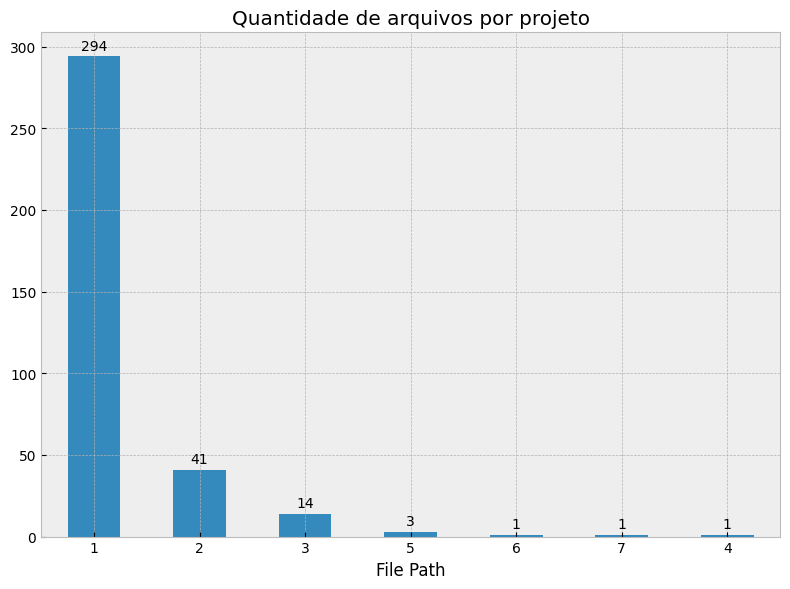

In [7]:
files_per_project = filter_nohelm[[
    'Owner', 'Project', 'File Path']].drop_duplicates()

files_counts = files_per_project.groupby(['Owner', 'Project']).count()

files_counts_values = files_counts['File Path'].value_counts()

display(files_counts[files_counts['File Path'] == 7])

plt.figure(figsize=(8, 6))

ax = files_counts_values.plot(
    kind='bar', stacked=True, ax=plt.gca())
ax.tick_params(axis="x", rotation=0)
add_labels(plt, files_counts_values.index,
           files_counts_values.values, hpadding=4)
plt.title("Quantidade de arquivos por projeto")
plt.tight_layout()
plt.show()


A maioria dos projetos tem apenas 1 arquivo com definição HPA

## Versões de HPA encontradas

'582'

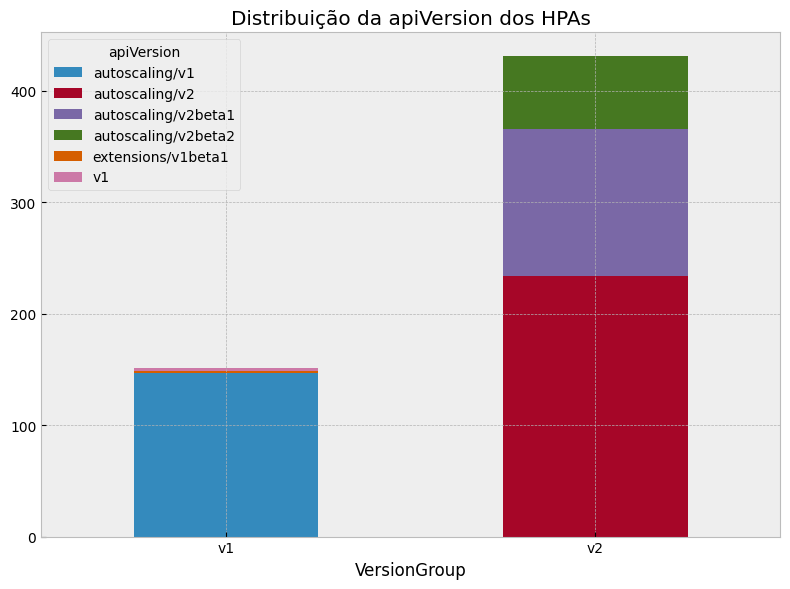

apiVersion,autoscaling/v1,autoscaling/v2,autoscaling/v2beta1,autoscaling/v2beta2,extensions/v1beta1,v1,Total
VersionGroup,,,,,,,
v1,147.0,0.0,0.0,0.0,2.0,2.0,151.0
v2,0.0,234.0,132.0,65.0,0.0,0.0,431.0


In [8]:
df_hpa_defs = filter_nohelm[[
    'Owner', 'Project', 'File Path', 'hpa_count', 'apiVersion']].drop_duplicates()

display(f"{df_hpa_defs.shape[0]}")

version_counts = df_hpa_defs['apiVersion'].value_counts().sort_index()
df_grouped = pd.DataFrame(
    {'apiVersion': version_counts.index, 'count': version_counts.values})

df_grouped['VersionGroup'] = df_grouped['apiVersion'].apply(func=map_version)

pivot_versions = df_grouped.pivot(
    index='VersionGroup', columns='apiVersion', values='count').fillna(0)

plt.figure(figsize=(8, 6))
ax = pivot_versions.plot(kind='bar', stacked=True, ax=plt.gca())
# add_labels(plt, pivot_versions.index, pivot_versions.values, hpadding=4)
ax.tick_params(axis="x", rotation=0)
plt.title("Distribuição da apiVersion dos HPAs")
plt.tight_layout()
plt.show()

pivot_versions['Total'] = pivot_versions.sum(axis=1)
display(pivot_versions)


Das definições HPA encontradas, cerca de 26% estão utilizando a versão v1 enquanto cerca de 74% utilizam a versão v2 em alguma de suas variações (v2beta1 ou v2beta2).

## Definições de HPA por arquivo

Em alguns projetos, um único arquivo yaml pode ter várias definições de HPA.

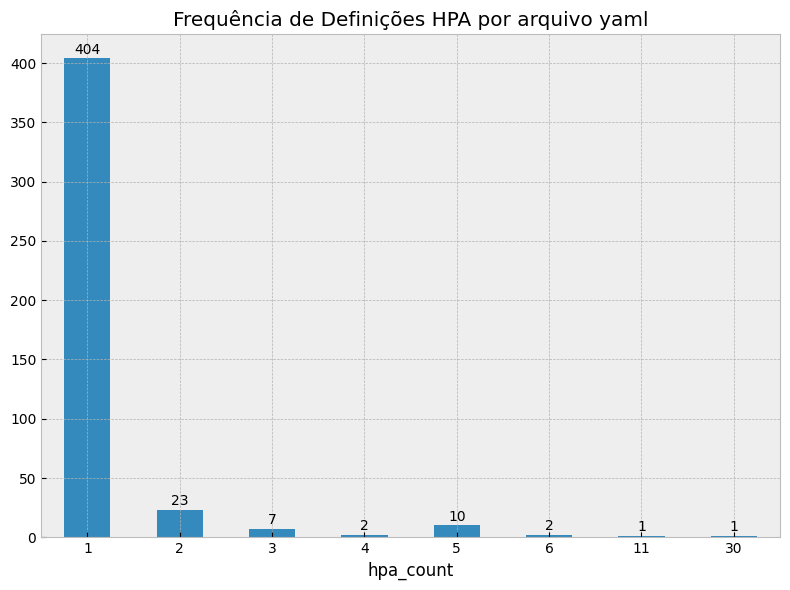

1303    search_results/solo-io/service-mesh-for-less-blog/tiered-app/30-namespace-app/ambient/waypoints/hpa-per-namespace.yaml
Name: File Path, dtype: object

1437    search_results/vigsachi/erlang/models/online_boutique/mem_autoscale/mem_autoscale_30.yaml
Name: File Path, dtype: object

In [9]:
filter_nohelm_nodups = (
    filter_nohelm
    .sort_values('hpa_count', ascending=False)
    .drop_duplicates(subset=['Owner', 'Project', 'File Path'], keep='first')
)

hpa_counts = filter_nohelm_nodups['hpa_count'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
ax = hpa_counts.plot(kind='bar')
add_labels(plt, hpa_counts.index, hpa_counts.values, hpadding=4)
ax.tick_params(axis="x", rotation=0)
plt.title("Frequência de Definições HPA por arquivo yaml")
plt.tight_layout()
plt.show()

display(
    filter_nohelm_nodups[filter_nohelm_nodups['hpa_count'] == 30]['File Path'])
display(
    filter_nohelm_nodups[filter_nohelm_nodups['hpa_count'] == 11]['File Path'])


Dos 458 arquivos identificados, 411 contém apenas 1 definição HPA. Alguns projetos apresentam arquivos com até 30 definições HPA.

## Tipos de métrica por definição HPA

23 definições HPA não apresentam métricas (usam os valores padrão)


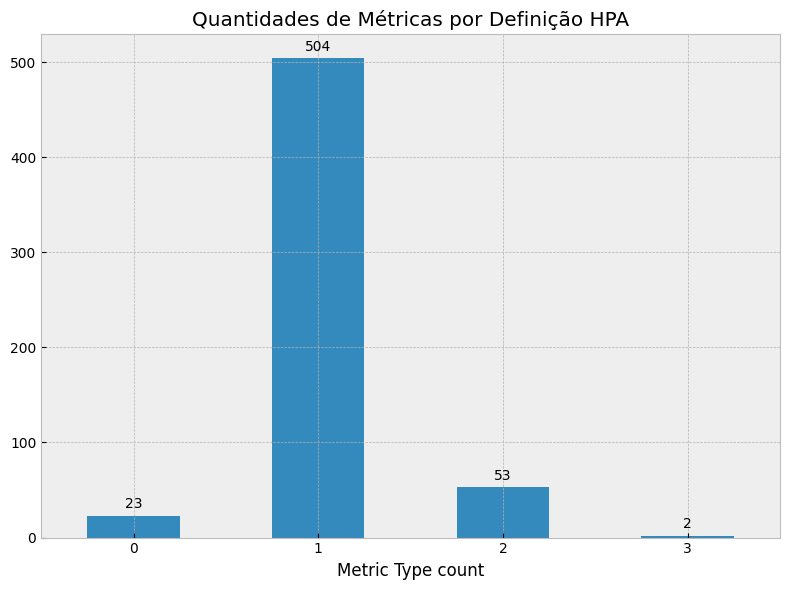

146    search_results/arafkarsh/k8s-quickstart/colima/Yamls/app/fusion-12-water-product-hpa-green.yaml
405                 search_results/ptrstpp950/k8s-allegro/exercises/28-kctl-hpa-scaling/template2.yaml
Name: File Path, dtype: object


In [10]:
files_n_def = filter_nohelm[['File Path', 'hpa_count']].drop_duplicates()
# display(files_n_def.shape[0])

metrics_per_def = filter_nohelm.groupby(['File Path', 'hpa_count'])[
    'Metric Type'].count().reset_index(name='Metric Type count')

zero_metrics = metrics_per_def[metrics_per_def['Metric Type count'] == 0]
# display(zero_metrics)
print(
    f"{zero_metrics.shape[0]} definições HPA não apresentam métricas (usam os valores padrão)")

metrics_counts = metrics_per_def['Metric Type count'].value_counts(
).sort_index()

plt.figure(figsize=(8, 6))
ax = metrics_counts.plot(kind='bar')
add_labels(plt, metrics_counts.index, metrics_counts.values, hpadding=8)
ax.tick_params(axis="x", rotation=0)
plt.title("Quantidades de Métricas por Definição HPA")
plt.tight_layout()
plt.show()

print(metrics_per_def[metrics_per_def['Metric Type count'] == 3]['File Path'])


# Tipos de Métricas

Investigando quais tipos de métricas são mais utilizadas, e quais métricas além das mais comuns (CPU e memória) são populares.

Para este passo, serão consideradas apenas as definições v2, já que as v1 contém apenas CPU e memória.

488

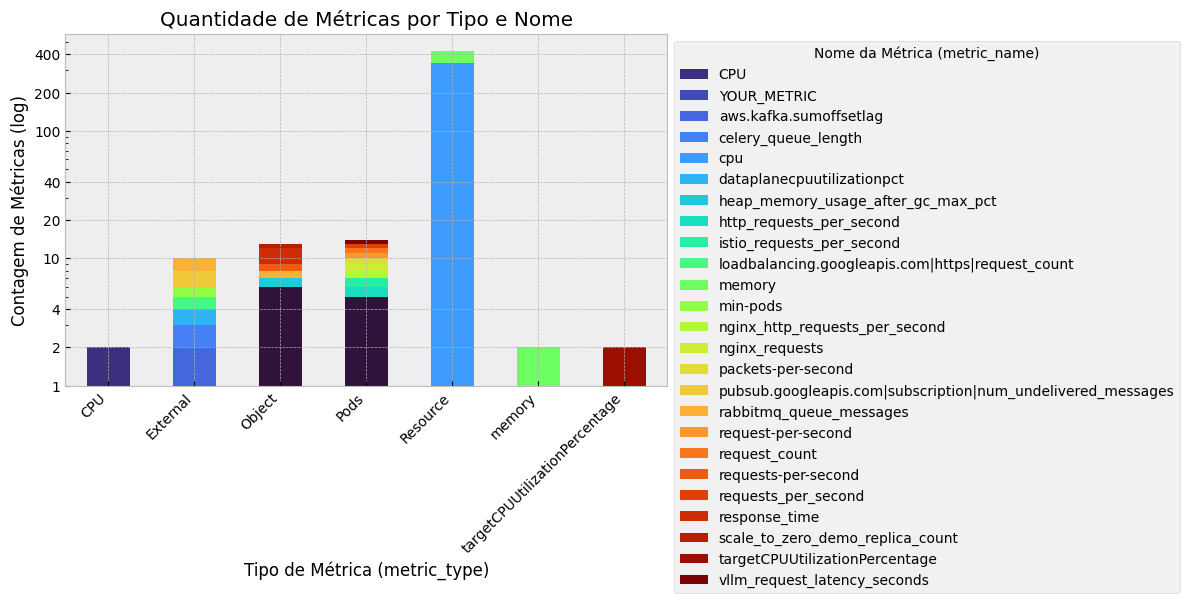

In [11]:
from matplotlib.ticker import LogLocator, FormatStrFormatter
df_v2 = filter_nohelm[filter_nohelm['apiVersion'].str.contains('v2')]
display(df_v2.shape[0])

v2_metrics = df_v2.groupby(
    ['Metric Type', 'Metric Name']).size().reset_index(name='counts')

pivot_table = v2_metrics.pivot(
    index='Metric Type', columns='Metric Name', values='counts').fillna(0)


fig = plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='turbo')
ax = plt.gca()
ax.set_yscale('log')
ax.yaxis.set_major_locator(LogLocator(base=10, subs=[1, 2, 4]))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.title('Quantidade de Métricas por Tipo e Nome')
plt.xlabel('Tipo de Métrica (metric_type)')
plt.ylabel('Contagem de Métricas (log)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nome da Métrica (metric_name)', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


As métricas do tipo Resource ofuscam os outros tipos devido à sua popularidade. O tipo ContainerResource apresenta 1 métrica que está escondida devido a escala logarítmica.

Abaixo são apresentados os mesmos valores removendo este tipo de métrica e utilizando escala linear.

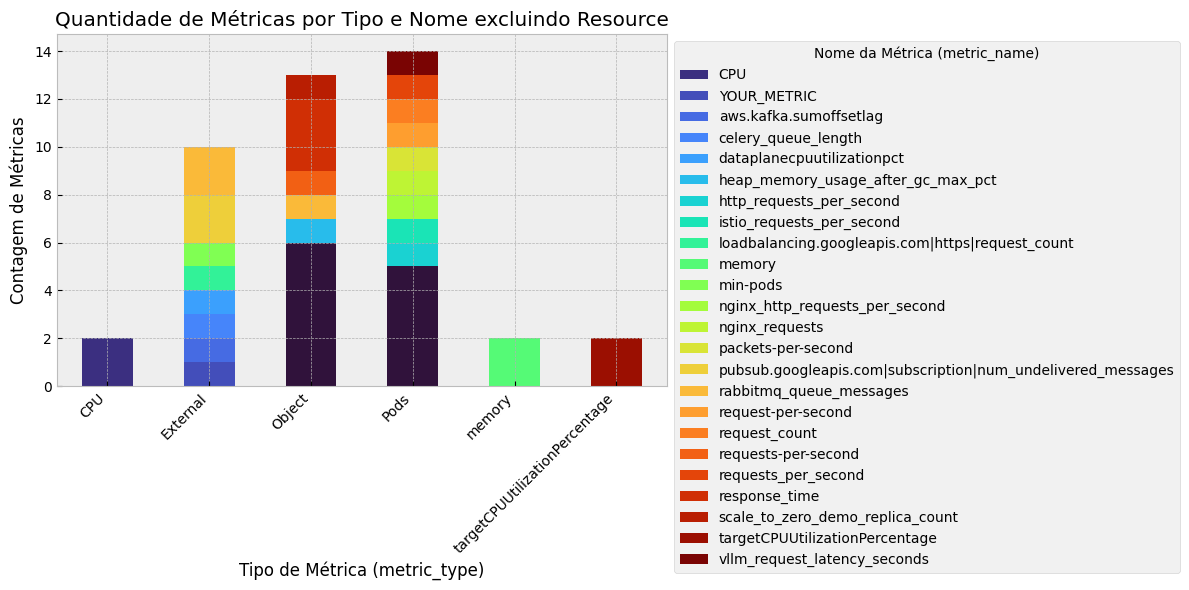

In [12]:
df_v2 = filter_nohelm[filter_nohelm['apiVersion'].str.contains('v2')]

df_v2_no_resource = df_v2[df_v2['Metric Type'] != 'Resource']

# display(df_v2_no_resource[df_v2_no_resource['Metric Type'] == 'External'])

v2_metrics = df_v2_no_resource.groupby(
    ['Metric Type', 'Metric Name']).size().reset_index(name='counts')

pivot_table = v2_metrics.pivot(
    index='Metric Type', columns='Metric Name', values='counts').fillna(0)

plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='turbo')
plt.title('Quantidade de Métricas por Tipo e Nome excluindo Resource')
plt.xlabel('Tipo de Métrica (metric_type)')
plt.ylabel('Contagem de Métricas')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Nome da Métrica (metric_name)', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


# Commits dos Projetos e Arquivos

Buscar relações entre as datas de criação dos projetos, últimos commits neles e últimos commits nos arquivos

## Conexão com o Github para recuperar informações do repositório e de commits dos arquivos

In [13]:
config = {
    **os.environ,
    **dotenv_values(".env")
}
github = GhApi(token=config['GITHUB_TOKEN'])


Dados do repositório

In [14]:
wait_for_reset('core')

repos_details = Parallel(n_jobs=32)(
    delayed(get_repo_details)(row) for _, row in filter_nohelm_nodups.iterrows()
)


In [15]:
df_details = pd.concat(repos_details)
display(df_details)


,stargazers_count,created_at,pushed_at
1303,3,2024-03-14T00:05:33Z,2024-06-24T16:23:15Z
1437,7,2024-03-02T23:08:27Z,2024-11-11T00:24:46Z
332,8,2022-04-18T00:04:54Z,2025-03-06T23:01:54Z
1241,6,2018-05-27T03:24:33Z,2023-11-30T02:52:04Z
990,4,2019-12-04T08:45:11Z,2023-01-27T01:10:39Z
...,...,...,...
1438,7,2024-03-02T23:08:27Z,2024-11-11T00:24:46Z
35,33,2022-03-29T17:30:46Z,2025-03-31T06:48:48Z
34,33,2022-03-29T17:30:46Z,2025-03-31T06:48:48Z
28,26,2022-08-05T14:08:27Z,2024-09-03T22:57:40Z


Dados de commit do arquivo que contém HPA

In [133]:
wait_for_reset('core')

paths_committed_at = Parallel(n_jobs=32)(
    delayed(get_file_first_last_commit)(row) for _, row in filter_nohelm_nodups.iterrows()
)


In [134]:
df_committed_at = pd.concat(paths_committed_at)
display(df_committed_at)


,file_first_commit,file_last_commit
1303,2024-03-19T19:28:50Z,2024-05-15T20:20:52Z
1437,2024-03-02T23:11:40Z,2024-03-02T23:11:40Z
332,2022-12-13T07:04:55Z,2022-12-13T07:04:55Z
1241,2023-11-30T02:51:53Z,2023-11-30T02:51:53Z
990,2019-12-04T08:45:20Z,2019-12-04T08:45:20Z
...,...,...
1438,2024-03-02T23:11:40Z,2024-03-02T23:11:40Z
35,2024-07-17T17:24:02Z,2025-03-25T16:22:54Z
34,2024-08-18T02:00:45Z,2025-03-03T21:06:54Z
28,2022-12-15T12:07:20Z,2022-12-15T12:07:20Z


Join dos dados obtidos com o filter_nohelm em um novo DataFrame

In [135]:
items_details = filter_nohelm_nodups.join([df_details, df_committed_at])

display(items_details)


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior,stargazers_count,created_at,pushed_at,file_first_commit,file_last_commit
1303,solo-io,service-mesh-for-less-blog,search_results/solo-io/service-mesh-for-less-blog/tiered-app/30-namespace-app/ambient/waypoints/hpa-per-namespace.yaml,30,autoscaling/v2,False,cpu,Resource,80,False,3,2024-03-14T00:05:33Z,2024-06-24T16:23:15Z,2024-03-19T19:28:50Z,2024-05-15T20:20:52Z
1437,vigsachi,erlang,search_results/vigsachi/erlang/models/online_boutique/mem_autoscale/mem_autoscale_30.yaml,11,autoscaling/v2beta1,False,memory,Resource,None,False,7,2024-03-02T23:08:27Z,2024-11-11T00:24:46Z,2024-03-02T23:11:40Z,2024-03-02T23:11:40Z
332,Young-ook,terraform-aws-fis,search_results/Young-ook/terraform-aws-fis/examples/blueprint/apps/sockshop/sockshop-demo-hpa.yaml,6,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,50,False,8,2022-04-18T00:04:54Z,2025-03-06T23:01:54Z,2022-12-13T07:04:55Z,2022-12-13T07:04:55Z
1241,shaohaiyang,easyKubernetes,search_results/shaohaiyang/easyKubernetes/samples/knative/istio.yaml,6,autoscaling/v2beta1,False,cpu,Resource,None,False,6,2018-05-27T03:24:33Z,2023-11-30T02:52:04Z,2023-11-30T02:51:53Z,2023-11-30T02:51:53Z
990,nikkkkhil,tensorRT-NVIDIA,search_results/nikkkkhil/tensorRT-NVIDIA/examples/90_Kubernetes/istio/rendered/istio-v1.0-minikube.yml,5,autoscaling/v2beta1,False,cpu,Resource,None,False,4,2019-12-04T08:45:11Z,2023-01-27T01:10:39Z,2019-12-04T08:45:20Z,2019-12-04T08:45:20Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1438,vigsachi,erlang,search_results/vigsachi/erlang/models/hello_world/mem_autoscale/mem_autoscale_10.yaml,1,autoscaling/v2beta1,False,memory,Resource,None,False,7,2024-03-02T23:08:27Z,2024-11-11T00:24:46Z,2024-03-02T23:11:40Z,2024-03-02T23:11:40Z
35,Azure,aks-app-routing-operator,search_results/Azure/aks-app-routing-operator/pkg/manifests/fixtures/nginx/default_version/kube-system.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,80,False,33,2022-03-29T17:30:46Z,2025-03-31T06:48:48Z,2024-07-17T17:24:02Z,2025-03-25T16:22:54Z
34,Azure,aks-app-routing-operator,search_results/Azure/aks-app-routing-operator/pkg/manifests/fixtures/nginx/v1.11.2/kube-system.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,80,False,33,2022-03-29T17:30:46Z,2025-03-31T06:48:48Z,2024-08-18T02:00:45Z,2025-03-03T21:06:54Z
28,Azure-Samples,dotnet-container-app,search_results/Azure-Samples/dotnet-container-app/src/ContainerApp.WebApp/k8s-deployment.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,20,False,26,2022-08-05T14:08:27Z,2024-09-03T22:57:40Z,2022-12-15T12:07:20Z,2022-12-15T12:07:20Z


Salva os dados completos em um CSV (Phase 4)

In [136]:
items_details.to_csv(
    f"partial_results/{datetime.now().replace(microsecond=0).isoformat()}-phase4.csv", index=False)


## Carrega dados da Phase 4 salvos anteriormente
Apenas o arquivo mais recente será considerado

In [146]:
items_details = phase4_files = utils.load_phase4_results()

items_details['created_at'] = pd.to_datetime(items_details['created_at'])
items_details['pushed_at'] = pd.to_datetime(items_details['pushed_at'])
items_details['file_first_commit'] = pd.to_datetime(
    items_details['file_first_commit'])
items_details['file_last_commit'] = pd.to_datetime(
    items_details['file_last_commit'])


Datas de lançamento de versões do HPA

In [197]:
releasedate_hpav1 = pd.to_datetime("2016-10-25").replace(tzinfo=None)
releasedate_hpav2beta1 = pd.to_datetime("2017-09-28").replace(tzinfo=None)
releasedate_hpav2beta2 = pd.to_datetime("2018-09-25").replace(tzinfo=None)
releasedate_hpav2 = pd.to_datetime("2021-12-07").replace(tzinfo=None)


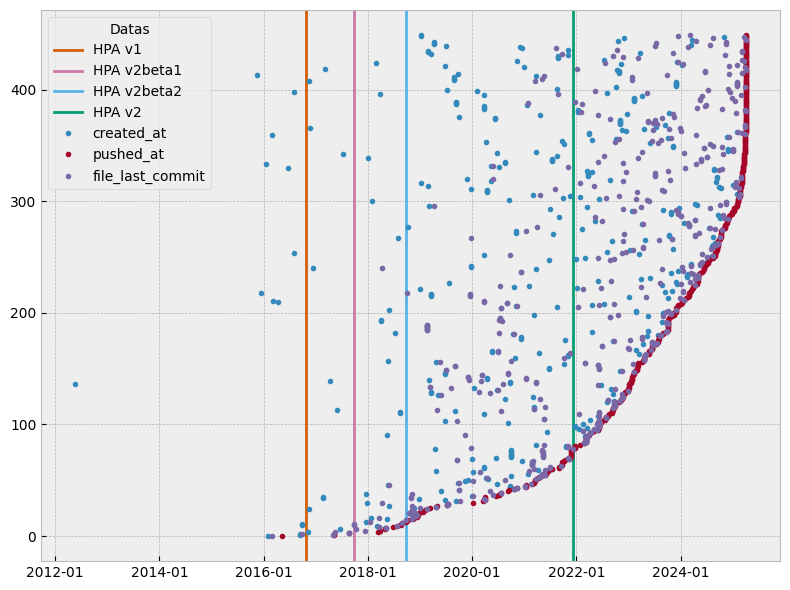

In [199]:
def dates_scatter_plot(df):
    plt.figure(figsize=(8, 6))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    plt.axvline(x=releasedate_hpav1, color=colors[4], label="HPA v1")
    plt.axvline(x=releasedate_hpav2beta1, color=colors[5], label="HPA v2beta1")
    plt.axvline(x=releasedate_hpav2beta2, color=colors[6], label="HPA v2beta2")
    plt.axvline(x=releasedate_hpav2, color=colors[7], label="HPA v2")

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

    plt.plot(df['created_at'], df.index,
             marker='.', linestyle='', label='created_at')
    plt.plot(df['pushed_at'], df.index,
             marker='.', linestyle='', label='pushed_at')
    plt.plot(df['file_last_commit'], df.index,
             marker='.', linestyle='', label='file_last_commit')

    plt.legend(title='Datas')

    plt.tight_layout()
    plt.show()


dates_scatter_plot(items_details.sort_values('pushed_at', ignore_index=True))


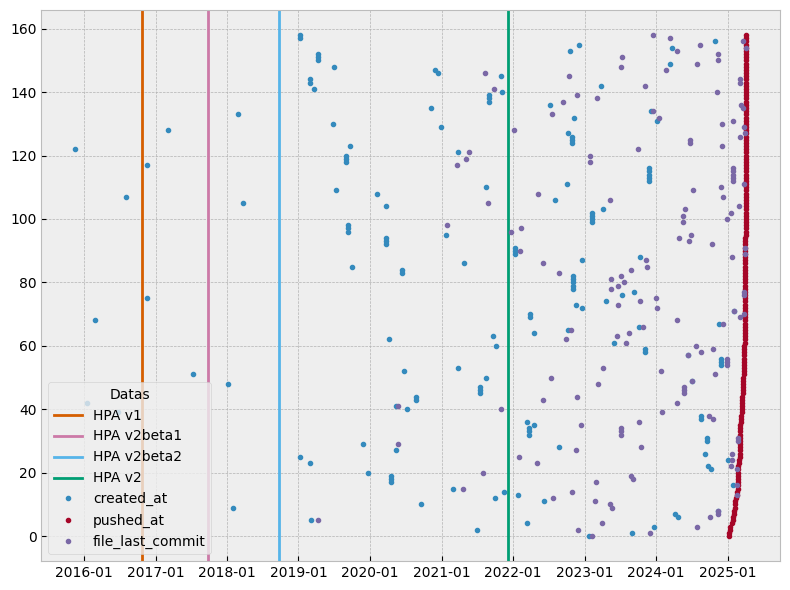

In [200]:
dates_scatter_plot(items_details[items_details['pushed_at'] > '2025-01-01'].sort_values(
    'pushed_at', ignore_index=True))


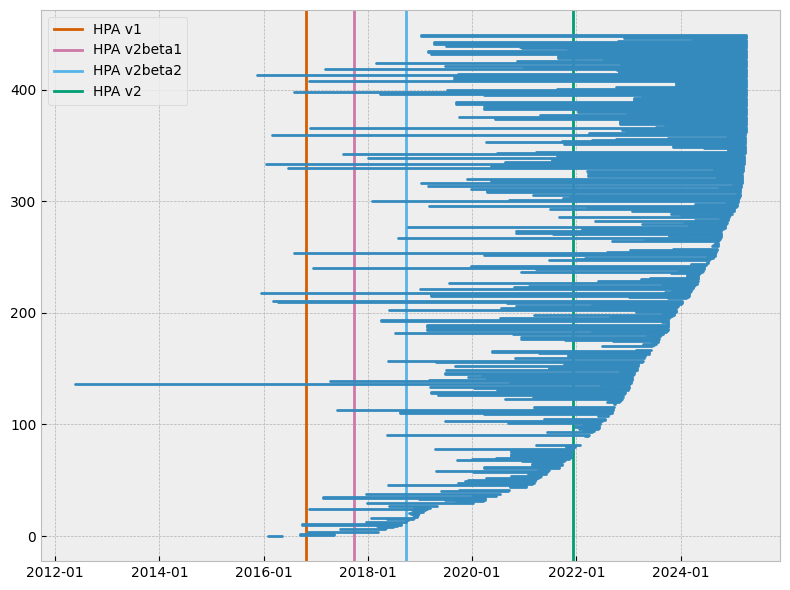

In [201]:
def timeline_plot(df):
    plt.figure(figsize=(8, 6))
    num_rows = df.shape[0]

    # obtém as cores do tema utilizado em uma lista
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    oldest_file_at = df['created_at'].sort_values(inplace=False).iloc[0]
    if releasedate_hpav1 > oldest_file_at.replace(tzinfo=None):
        plt.axvline(x=releasedate_hpav1, color=colors[4], label="HPA v1")
    plt.axvline(x=releasedate_hpav2beta1, color=colors[5], label="HPA v2beta1")
    plt.axvline(x=releasedate_hpav2beta2, color=colors[6], label="HPA v2beta2")
    plt.axvline(x=releasedate_hpav2, color=colors[7], label="HPA v2")

    for i in df.index:
        # x1 = df.loc[i, 'created_at']
        x2 = df.loc[i, 'created_at']
        x3 = df.loc[i, 'pushed_at']
        normalized_i = i / (num_rows - 1) if num_rows > 1 else 0.5
        plt.plot([x2, x3], [i, i], linewidth=2,
                 color=colors[0], solid_capstyle='round')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.legend()
    plt.tight_layout()
    plt.show()


timeline_plot(items_details.sort_values('pushed_at', ignore_index=True))


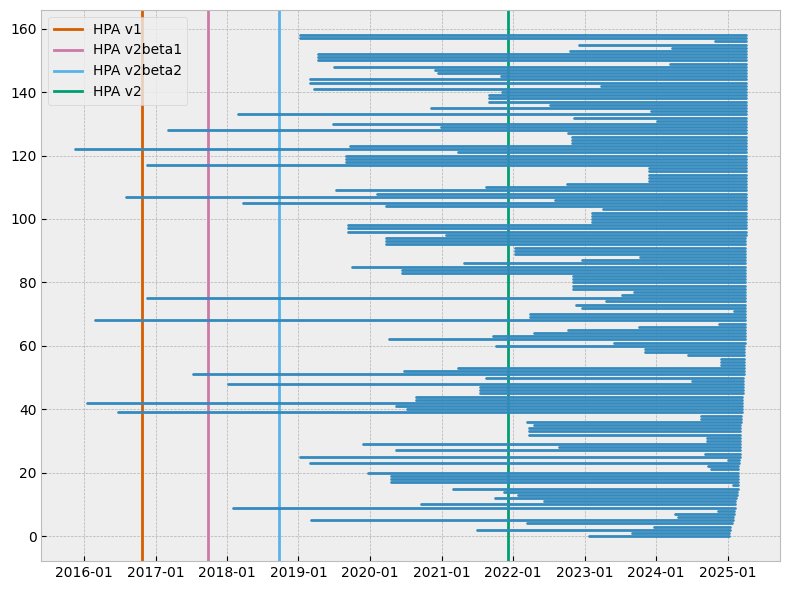

In [202]:
timeline_plot(items_details[items_details['pushed_at'] >
              '2025-01-01'].sort_values('pushed_at', ignore_index=True))


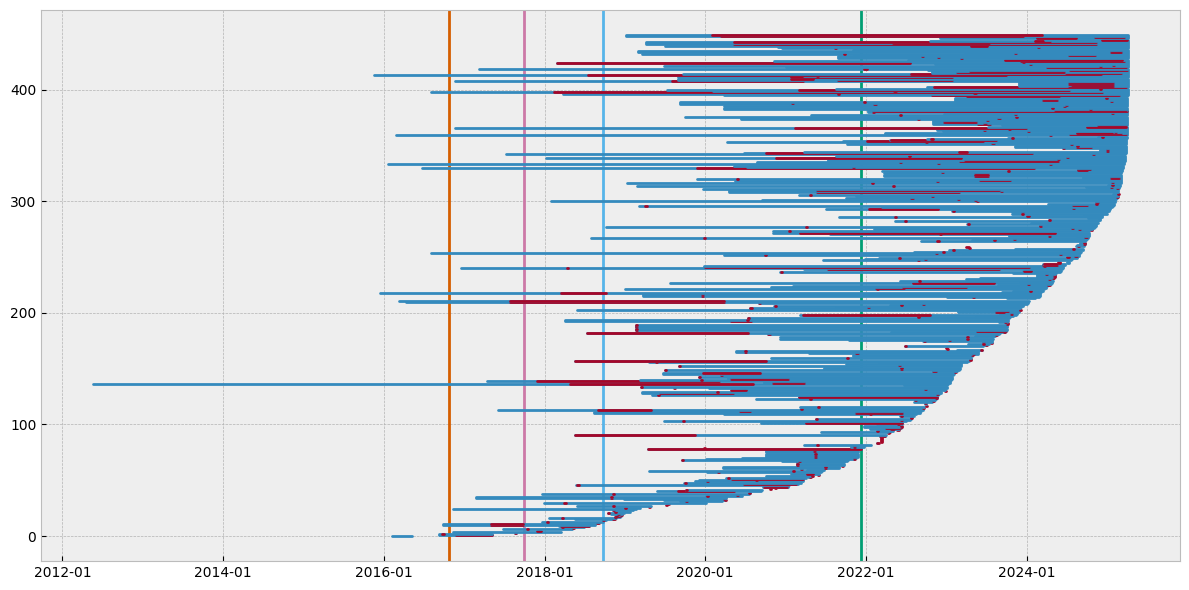

In [207]:
def repo_timeline_plot(df):
    fig, ax = plt.subplots(figsize=(12, 6))

    # obtém as cores do tema utilizado em uma lista
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    oldest_time = df['created_at'].sort_values(inplace=False).iloc[0]

    if releasedate_hpav1 > oldest_time.replace(tzinfo=None):
        plt.axvline(x=releasedate_hpav1, color=colors[4], label="HPA v1")
    if releasedate_hpav1 > oldest_time.replace(tzinfo=None):
        plt.axvline(x=releasedate_hpav2beta1, color=colors[5], label="HPA v2beta1")
    if releasedate_hpav1 > oldest_time.replace(tzinfo=None):
        plt.axvline(x=releasedate_hpav2beta2, color=colors[6], label="HPA v2beta2")
    plt.axvline(x=releasedate_hpav2, color=colors[7], label="HPA v2")

    for i in range(df.shape[0]):
        x1 = mdates.date2num(df.iloc[i]['created_at'])
        x2 = mdates.date2num(df.iloc[i]['pushed_at'])
        plt.plot(
            [x1, x2],
            [i, i],
            linewidth='2',
            solid_capstyle='round',
            color=colors[0]
        )

        x3 = mdates.date2num(df.iloc[i]['file_first_commit'])
        x4 = mdates.date2num(df.iloc[i]['file_last_commit'])
        # quando há apenas um commit, criar um valor mínimo para exibir no gráfico
        if x3 == x4:
            x4 = x4 + 5

        plt.plot(
            [x3, x4],
            [i, i],
            linewidth='2',
            solid_capstyle='round',
            color=colors[1]
        )

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    # ax.set_yticks(range(0, df.shape[0]))
    # ax.set_yticklabels(df['repo'])

    plt.tight_layout()
    plt.show()


repo_timeline_plot(items_details.sort_values('pushed_at', ignore_index=True))


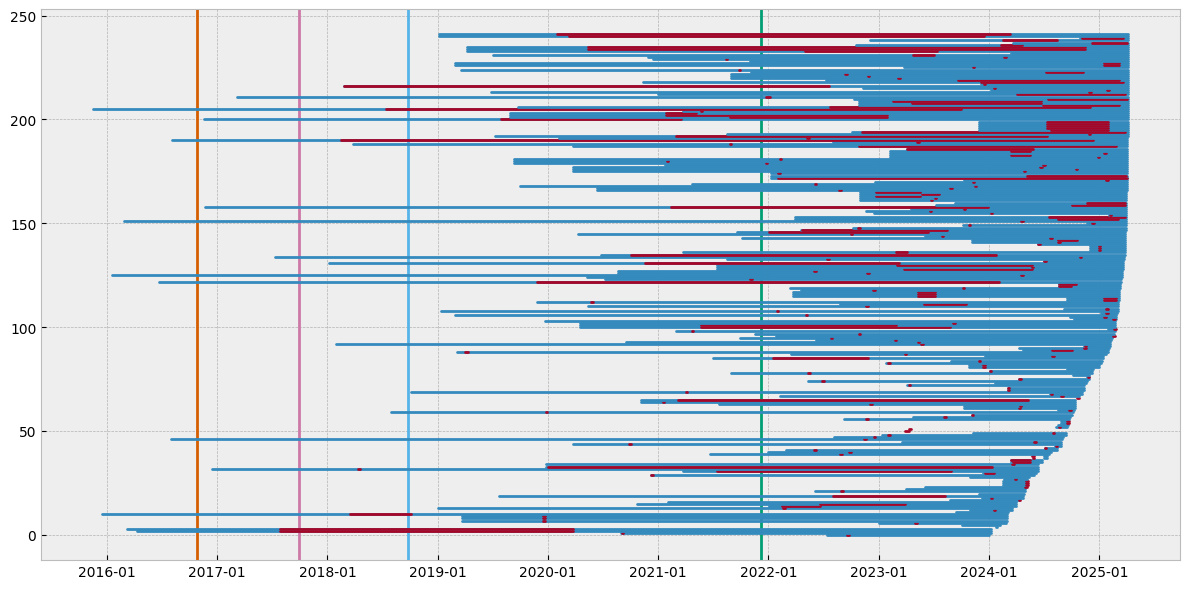

In [208]:
repo_timeline_plot(items_details[items_details['pushed_at'] > '2024-01-01'].sort_values('pushed_at', ignore_index=True))

In [173]:
items_details[items_details['Owner'] == 'GoogleCloudPlatform']


,Owner,Project,File Path,hpa_count,apiVersion,Is Helm Template,Metric Name,Metric Type,Target Value,Has Behavior,stargazers_count,created_at,pushed_at,file_first_commit,file_last_commit
364,GoogleCloudPlatform,cloud-learning-platform,search_results/GoogleCloudPlatform/cloud-learning-platform/microservices/dashboard/kustomize/custom/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,60,False,34,2022-10-31 14:04:20+00:00,2025-03-31 22:30:07+00:00,2023-06-23 04:15:00+00:00,2023-06-23 04:15:00+00:00
383,GoogleCloudPlatform,k8s-config-connector,search_results/GoogleCloudPlatform/k8s-config-connector/config/installbundle/components/webhook/autoscaler.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,70,False,941,2019-04-08 07:41:30+00:00,2025-04-06 14:26:36+00:00,2022-05-03 01:36:58+00:00,2023-07-13 20:49:51+00:00
384,GoogleCloudPlatform,k8s-config-connector,search_results/GoogleCloudPlatform/k8s-config-connector/install-bundles/install-bundle-gcp-identity/0-cnrm-system.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,70,False,941,2019-04-08 07:41:30+00:00,2025-04-06 14:26:36+00:00,2020-05-11 16:39:12+00:00,2024-11-13 02:23:13+00:00
385,GoogleCloudPlatform,k8s-config-connector,search_results/GoogleCloudPlatform/k8s-config-connector/install-bundles/install-bundle-workload-identity/0-cnrm-system.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,70,False,941,2019-04-08 07:41:30+00:00,2025-04-06 14:26:36+00:00,2020-05-11 16:39:12+00:00,2024-11-13 02:23:13+00:00
386,GoogleCloudPlatform,cloud-learning-platform,search_results/GoogleCloudPlatform/cloud-learning-platform/microservices/prior_learning_assessment/kustomize/custom/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,60,False,34,2022-10-31 14:04:20+00:00,2025-03-31 22:30:07+00:00,2023-07-06 13:24:50+00:00,2023-07-08 14:20:35+00:00
387,GoogleCloudPlatform,cloud-learning-platform,search_results/GoogleCloudPlatform/cloud-learning-platform/microservices/lti/kustomize/prod/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,60,False,34,2022-10-31 14:04:20+00:00,2025-03-31 22:30:07+00:00,2022-12-22 10:17:05+00:00,2023-05-17 12:25:14+00:00
388,GoogleCloudPlatform,cloud-learning-platform,search_results/GoogleCloudPlatform/cloud-learning-platform/microservices/lti/kustomize/custom/hpa.yaml,1,autoscaling/v2,False,cpu,Resource,60,False,34,2022-10-31 14:04:20+00:00,2025-03-31 22:30:07+00:00,2022-12-22 10:17:05+00:00,2023-05-17 12:25:14+00:00
389,GoogleCloudPlatform,cloud-builders,search_results/GoogleCloudPlatform/cloud-builders/gke-deploy/deployer/testing/expected-suggested/no-config.yaml,1,autoscaling/v2,False,cpu,Resource,80,False,1395,2016-06-21 17:01:33+00:00,2025-03-12 22:13:00+00:00,2019-11-25 16:56:21+00:00,2024-02-02 20:44:49+00:00
390,GoogleCloudPlatform,click-to-deploy-solutions,search_results/GoogleCloudPlatform/click-to-deploy-solutions/gke-autopilot-hpa/build/hpa-example.yaml,1,autoscaling/v1,False,targetCPUUtilizationPercentage,targetCPUUtilizationPercentage,50,False,95,2022-12-16 18:26:08+00:00,2025-03-31 10:43:21+00:00,2024-01-06 16:46:28+00:00,2024-01-06 16:46:28+00:00
391,GoogleCloudPlatform,apigee-anthos-service-mesh-demo,search_results/GoogleCloudPlatform/apigee-anthos-service-mesh-demo/api-ingress/kubernetes-manifests/deployment.yaml,1,autoscaling/v2,False,cpu,Resource,80,False,39,2022-04-20 00:11:55+00:00,2025-03-28 22:43:36+00:00,2022-04-22 19:23:17+00:00,2023-08-14 21:45:18+00:00


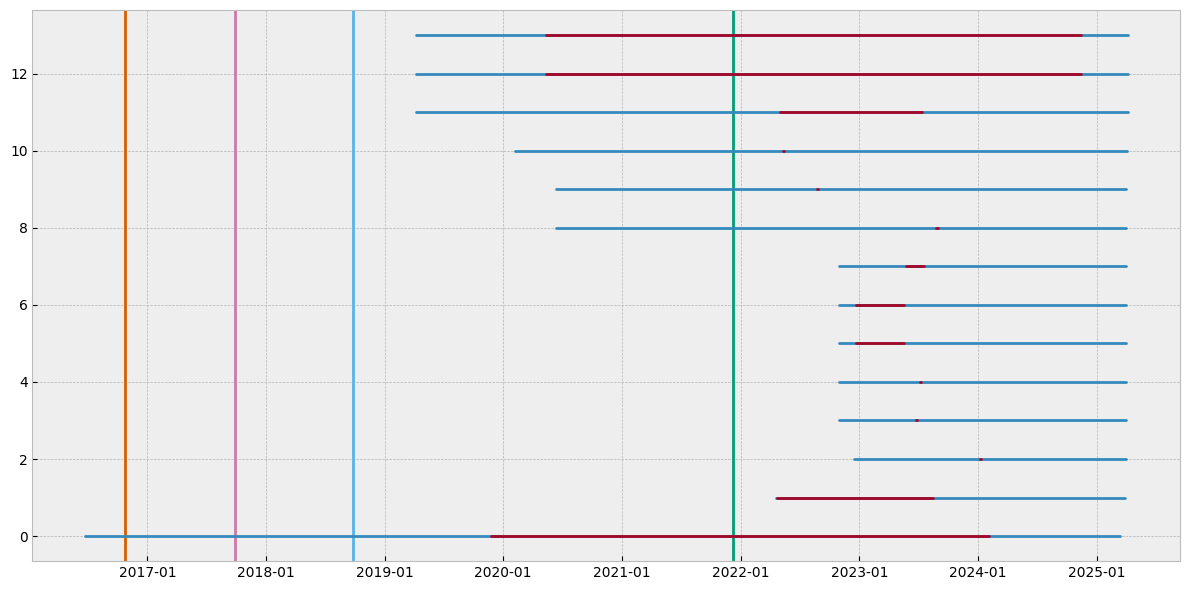

In [209]:
repo_timeline_plot(items_details[items_details['Owner'] == 'GoogleCloudPlatform'].sort_values('pushed_at', ignore_index=True))

In [181]:
items_details[items_details['pushed_at'] > '2025-01-01'].shape[0]


159

# Baixar Histórico de Arquivos para Compará-los

In [182]:
display(items_details.iloc[389])


Owner                                                                                                            GoogleCloudPlatform
Project                                                                                                               cloud-builders
File Path            search_results/GoogleCloudPlatform/cloud-builders/gke-deploy/deployer/testing/expected-suggested/no-config.yaml
hpa_count                                                                                                                          1
apiVersion                                                                                                            autoscaling/v2
Is Helm Template                                                                                                               False
Metric Name                                                                                                                      cpu
Metric Type                                                          

In [183]:
display(download_file_history(items_details.iloc[389]))


found 3 commits


None

## Analisa versões anteriores do HPA

2024-02-02T20:44:49Z autoscaling/v2
19755.86445601852
2020-01-28T17:59:44Z autoscaling/v2beta1
18289.749814814815
2019-11-25T16:56:21Z autoscaling/v2beta1
18225.70579861111


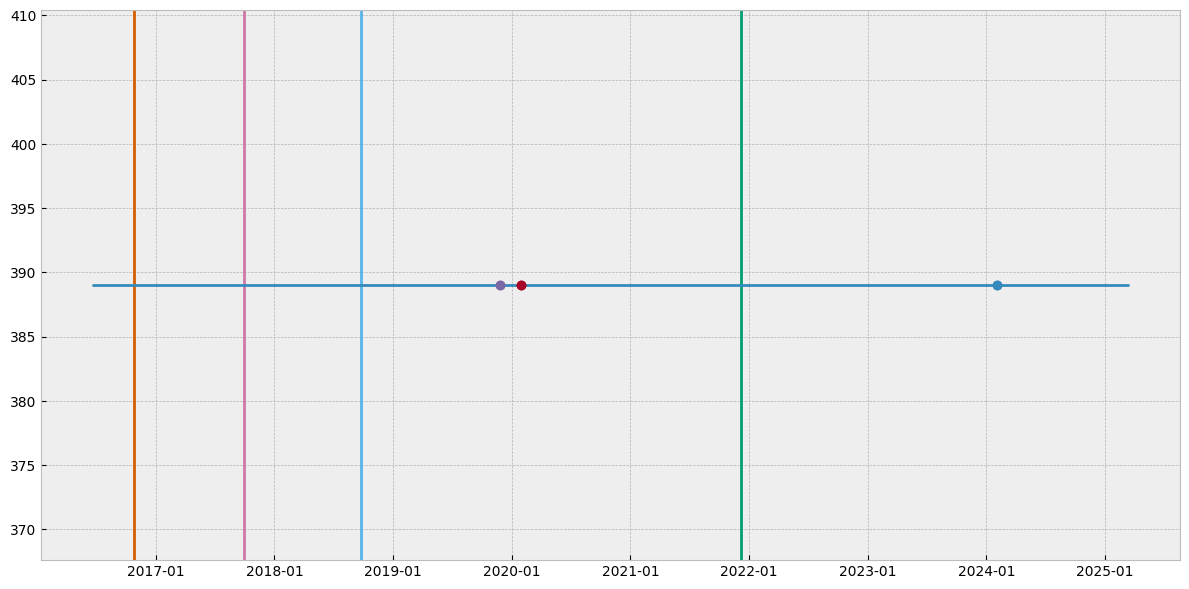

In [211]:
def get_apiversion_history(row):
    root_dir = 'repos_history'
    repo_path = Path(root_dir, row['Owner'], row['Project'])

    hpa_commits = {}
    for dirpath, dirnames, filenames in os.walk(f"{repo_path}"):
        for filename in filenames:
            file_path = Path(dirpath, filename)
            commit_path = Path(dirpath).relative_to(repo_path).parts[0]

            hpa_definitions = process_yaml_file(file_path)
            hpa_commits[commit_path] = hpa_definitions[0]['apiVersion']
    
    fig, ax = plt.subplots(figsize=(12, 6))

    # obtém as cores do tema utilizado em uma lista
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    if releasedate_hpav1 > pd.to_datetime(row['created_at']).replace(tzinfo=None):
        plt.axvline(x=releasedate_hpav1, color=colors[4], label="HPA v1")
    if releasedate_hpav1 > pd.to_datetime(row['created_at']).replace(tzinfo=None):
        plt.axvline(x=releasedate_hpav2beta1, color=colors[5], label="HPA v2beta1")
    if releasedate_hpav1 > pd.to_datetime(row['created_at']).replace(tzinfo=None):
        plt.axvline(x=releasedate_hpav2beta2, color=colors[6], label="HPA v2beta2")
    plt.axvline(x=releasedate_hpav2, color=colors[7], label="HPA v2")

    x1 = mdates.date2num(row['created_at'])
    x2 = mdates.date2num(row['pushed_at'])
    plt.plot(
        [x1, x2],
        [row.name, row.name],
        linewidth='2',
        solid_capstyle='round',
        color=colors[0]
    )

    for date, version in hpa_commits.items():
        print(date, version)
        x = mdates.datestr2num(date)
        print(x)
        plt.plot(
            [x, x],
            [row.name, row.name],
            linewidth='0',
            marker='o'
        )

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())

    plt.tight_layout()
    plt.show()

get_apiversion_history(items_details.iloc[389])
